# QoI-aware encoder-decoders employing Partition of Unity Networks (POUnets)

This demo takes the general formulation of QoI-aware encoder-decoders available in PCAfold and implements POUnets as the decoder.

In [1]:
from PCAfold import QoIAwareProjectionPOUnet, init_uniform_partitions, PCA, center_scale, PartitionOfUnityNetwork
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf

We will load the combustion dataset and remove temperature from the state variable list.

In [2]:
X = np.genfromtxt('H2-air-state-space.csv', delimiter=',')[:,1:-2]
S_X = np.genfromtxt('H2-air-state-space-sources.csv', delimiter=',')[:,1:-2]
X_names = np.genfromtxt('H2-air-state-space-names.csv', delimiter='\n', dtype=str)[1:-2]
X_names


array(['H', 'H2', 'O', 'OH', 'H2O', 'O2', 'HO2', 'H2O2'], dtype='<U4')

We then initialize the encoder weights using PCA. Notice how the 2D manifold is squeezed tightly and has overlapping states in some regions.
The manifold is colored by the first projected source term.

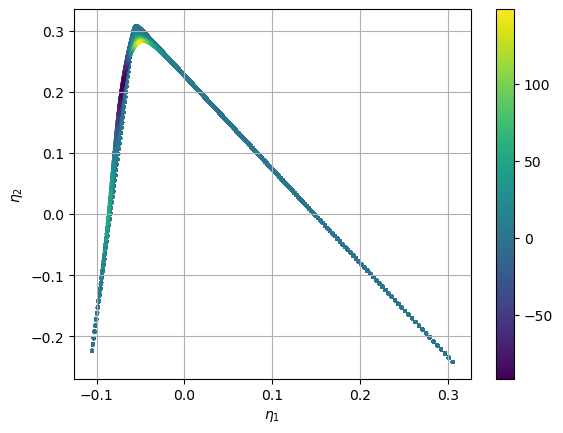

In [3]:
n_components = 2

pca = PCA(X, n_components=n_components, scaling='auto')
encoder_weights_init = pca.A[:,:n_components]

X_projected = X.dot(encoder_weights_init)
S_X_projected = S_X.dot(encoder_weights_init)

plt.scatter(X_projected[:,0], X_projected[:,1],s=3, c=S_X_projected[:,0], cmap='viridis')
plt.colorbar()
plt.grid()
plt.xlabel('$\eta_1$')
plt.ylabel('$\eta_2$')
plt.show()


Next, we finish initializing the encoder-decoder with the POUnet parameters.
The helper function `init_uniform_partitions` is used as done in the POUnet demo, but note the independent variable space for the POUnet is the projected state variables `X_projected`.
We have chosen a linear basis below.

When building the graph for the encoder-decoder, a function is required for computing the dependent training variables (QoIs).
This allows for flexibility in using the projection parameters, which get updated themselves during training, for the dependent variable definitions.
Therefore, the projection training can be informed by how well the projected source terms are represented, for example.
The function must take in the encoder weights as an argument, but these do not have to be used.
We also perform a nonlinear transformation on the source terms, which can help penalize projections introducing overlap in values.
Below, we build a function that computes the projected source terms and concatenates these values with those of the OH and water mass fractions.
These four variables provide the QoIs for which the loss function is computed during training.
Note the QoI function must be written using tensorflow operations.

The graph is then built.
Below we have turned on the optional `constrain_positivity` flag.
As mass fractions are naturally positive, this only penalizes projections that create negative projected source terms.
This can have advantages in simplifying regression and reducing the impact of regression errors with the wrong sign during simulation.

Finally, we train the `QoIAwareProjectionPOUnet` for 1000 iterations, archiving every 100th iteration, and save the parameters with the lowest overall errors.
This is for demonstration, but more iterations are generally needed to converge to an optimal solution.

In [4]:
ednet = QoIAwareProjectionPOUnet(encoder_weights_init, 
                                 **init_uniform_partitions([8,8], X_projected), 
                                 basis_type='linear'
                                )

# define the function to produce the dependent variables for training
def define_dvar(proj_weights):
    dvar_y = tf.Variable(X[:,3:5], name='non_transform', dtype=tf.float64) # mass fractions for OH and H2O
    
    dvar_s = tf.Variable(np.expand_dims(S_X, axis=2), name='non_transform', dtype=tf.float64)
    dvar_s = ednet.tf_projection(dvar_s, nobias=True) # projected source terms
    dvar_st = tf.math.sqrt(tf.cast(tf.abs(dvar_s+1.e-4), dtype=tf.float64)) * tf.math.sign(dvar_s+1.e-4)+1.e-2 * tf.math.sign(dvar_s+1.e-4) # power transform source terms
    dvar_st_norm = dvar_st/tf.reduce_max(tf.cast(tf.abs(dvar_st), dtype=tf.float64), axis=0, keepdims=True) # normalize

    dvar = tf.concat([dvar_y, dvar_st_norm], axis=1) # train on combination
    return dvar

ednet.build_training_graph(X, define_dvar, error_type='abs', constrain_positivity=True)

ednet.train(1000, archive_rate=100, verbose=True)


------------------------------------------------------------
   iteration |   mean sqr |      % max  |    sum sqr
------------------------------------------------------------
         100 |   7.85e-04 |      79.79% |   4.56e+01
resetting best error
         200 |   6.72e-04 |      79.53% |   3.91e+01
resetting best error
         300 |   6.04e-04 |      78.90% |   3.51e+01
resetting best error
         400 |   5.29e-04 |      78.87% |   3.07e+01
resetting best error
         500 |   4.49e-04 |      76.84% |   2.61e+01
resetting best error
         600 |   3.53e-04 |      73.46% |   2.05e+01
resetting best error
         700 |   2.20e-04 |      67.99% |   1.28e+01
resetting best error
         800 |   1.18e-04 |      59.24% |   6.86e+00
resetting best error
         900 |   9.86e-05 |      59.00% |   5.73e+00
resetting best error
        1000 |   9.25e-05 |      59.07% |   5.37e+00
resetting best error


The learning rate (default 1e-3) and least squares l2 regularization (default 1e-10) can also be updated at any time.

In [5]:
ednet.update_lr(1.e-4)
ednet.update_l2reg(1.e-11)

ednet.train(200, archive_rate=100, verbose=True)


updating lr: 0.0001
updating l2reg: 1e-11
------------------------------------------------------------
   iteration |   mean sqr |      % max  |    sum sqr
------------------------------------------------------------
         100 |   9.03e-05 |      59.40% |   5.25e+00
resetting best error
         200 |   8.96e-05 |      59.41% |   5.21e+00
resetting best error


We can look at the trained projection weights:

In [6]:
print(ednet.projection_weights)

[[-0.35640105  0.05729153]
 [ 0.42022997  0.05765012]
 [-0.48311619 -0.24169431]
 [-0.24244533 -0.20839019]
 [-0.11743472  0.78807212]
 [-0.24317541 -0.00543714]
 [-1.16916608 -0.3213446 ]
 [-1.52308699  0.10786119]]


We can look at the projection after the progress in training.
We see how the projected source term values are closer to being positive than before and the overlap has been removed.
We would expect further training to create more separation between observations.
Other QoIs for training may also lead to better separation faster.


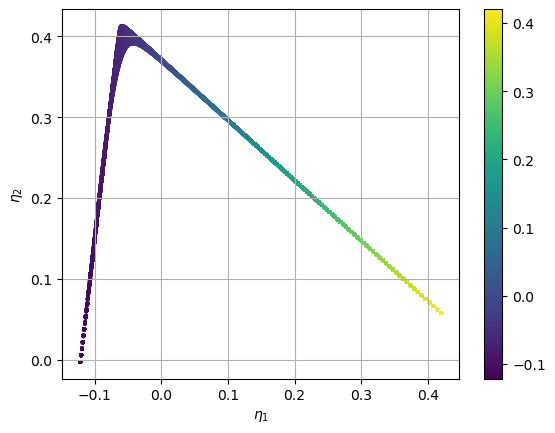

In [7]:
X_projected = ednet.projection(X)
S_X_projected = ednet.projection(X, nobias=True)

plt.scatter(X_projected[:,0], X_projected[:,1],s=3, c=S_X_projected[:,0], cmap='viridis')
plt.colorbar()
plt.grid()
plt.xlabel('$\eta_1$')
plt.ylabel('$\eta_2$')
plt.show()


Below we grab the archived states during training and visualize the errors.

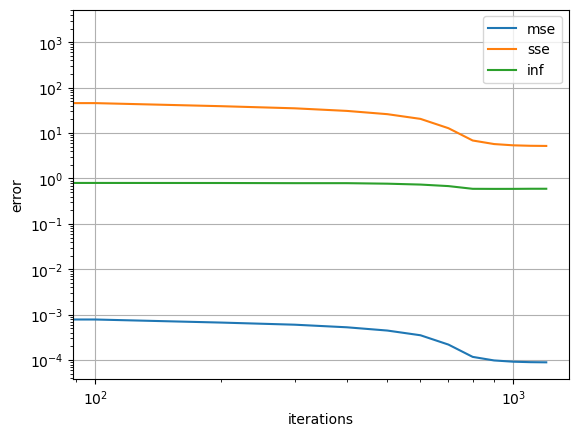

In [8]:
err_dict = ednet.training_archive

for k in ['mse', 'sse', 'inf']:
    plt.loglog(ednet.iterations,err_dict[k],'-', label=k)
plt.grid()
plt.xlabel('iterations')
plt.ylabel('error')
plt.legend()
plt.show()


We may also save and load a `QoIAwareProjectionPOUnet` to/from file.
Rebuilding the graph is not necessary to grab the projection off a loaded `QoIAwareProjectionPOUnet`.

In [9]:
# Save the data to a file
ednet.write_data_to_file('filename.pkl')

# reload projection data from file
ednet2 = QoIAwareProjectionPOUnet.load_from_file('filename.pkl')

#compute projection without needing to rebuild graph:
X_projected = ednet2.projection(X)


It can then be useful to create multiple POUnets for separate variables using the same trained projection and partitions from the `QoIAwareProjectionPOUnet`.
Below we demonstrate this for the water mass fraction.

performing least-squares solve


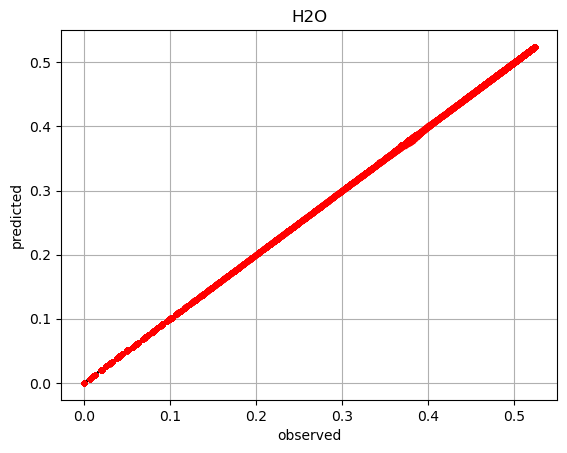

In [10]:
net = PartitionOfUnityNetwork(
                             partition_centers=ednet.partition_centers,
                             partition_shapes=ednet.partition_shapes,
                             basis_type=ednet.basis_type,
                             ivar_center=ednet.proj_ivar_center,
                             ivar_scale=ednet.proj_ivar_scale
                            )
i_dvar = 4
dvar1 = X[:,i_dvar]
net.build_training_graph(ednet.projection(X), dvar1)
net.lstsq()

pred = net(ednet.projection(X))
plt.plot(dvar1, dvar1, 'k-')
plt.plot(dvar1, pred.ravel(), 'r.')
plt.title(X_names[i_dvar])
plt.grid()
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()


There is also an option when building the `QoIAwareProjectionPOUnet` graph of separating trainable from nontrainable projection weights.
This can be useful if certain dimensions of the projection are predefined, such as mixture fraction commonly used in combustion.
In order to set certain columns of the projection weight matrix constant, specify the first index for which the weights are trainable (`first_trainable_idx`).

Below is an example of holding the first weights constant.
We see how the second weights change after training, but the first do not.


In [11]:
ednet2 = QoIAwareProjectionPOUnet.load_from_file('filename.pkl')
ednet2.build_training_graph(X, define_dvar, first_trainable_idx=1)
old_weights = ednet2.projection_weights
ednet2.train(10, archive_rate=1)
print('difference in weigths before and after training:\n', old_weights-ednet2.projection_weights)


difference in weigths before and after training:
 [[ 0.        -0.001    ]
 [ 0.        -0.001    ]
 [ 0.        -0.001    ]
 [ 0.        -0.001    ]
 [ 0.         0.001    ]
 [ 0.         0.001    ]
 [ 0.         0.001    ]
 [ 0.         0.0009999]]
